```
This notebook sets up barotropic drifters in the Oslofjord
Copyright (C) 2022 - 2023 SINTEF Digital
Copyright (C) 2022 - 2023 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 9e2194949a236a78754252e0e34f69f9b1e1823f on branch reduced_gravity


# Oslofjord: Barotropic Drifters

Not actively used!!

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, Common, NetCDFInitialization, WindStress, OceanographicUtilities

from gpuocean.SWEsimulators import CDKLM16

In [4]:
%cuda_context_handler barotropic_gpu_ctx

Path to the test file

In [5]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"

## Inspecting file structure and content

In [6]:
from netCDF4 import Dataset
nc = Dataset(source_url)

In [7]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 720, s_rho: 42, s_w: 43, eta_rho: 741, xi_rho: 397, xi_u: 396, eta_v: 740)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-06-30T13:00:00 ... 2014-07-3...
  * s_rho       (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w         (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/15)
    projection  int32 ...
    Cs_r        (s_rho) float64 ...
    Cs_w        (s_w) float64 ...
    h           (eta_rho, xi_rho) float32 ...
    mask_rho    (eta_rho, xi_rho) float32 ...
    angle       (eta_rho, xi_rho) float32 ...
    ...          ...
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 ...
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 ...
    lat_rho     (eta_rho, xi_rho) float32 ...
    lon_rho     (eta_rho, xi_rho) float32 ...

Animation utils

In [8]:
sys.path.append(os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir)))
from utils import animation_utils

## Generating GPUOcean Simulation from Input

General parameters

In [9]:
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

Simulation span: 6h!

In [10]:
t_start = 5*24
t_stop =  t_start + 6

T = (t_stop-t_start)*3600  #Input
timestep_indices = [list(np.arange(t_start, t_stop+1))]

Generating wind fields

In [11]:
from gpuocean.utils import WindStress

def generate_wind_field(wind_angle_deg, t_start_index, T):
    """Generating WindStress object with spatially constant, hourly varying wind 
    according to the standard shape in Oslofjord (see Oslofjord-ArtificialParameters.ipynb)
    
    wind_angle_deg - angle of wind field towards north in degree!
    t_start_index  - index for the time when generated wind field is supposed to start
    T              - time span for which the wind field is generated in seconds
    """

    wind_angle = np.deg2rad(wind_angle_deg)

    # Reference wind speed for 0 - 24h 
    wind_u_ref = np.zeros(24)
    wind_u_ref[:10] = -0.5*(np.sin(2*np.pi*(np.arange(0,10)-2.5)/10)+1)
    wind_u_ref[10:] = 5*(np.sin(2*np.pi*(np.arange(10,24)+0.5)/14)+1)

    # Wind fields for 0 - 24h
    wind_u = list(np.cos(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32))
    wind_v = list(np.sin(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32))

    # Shifting that reference hours align with t_0
    shift = datetime.datetime.utcfromtimestamp(nc["ocean_time"][t_start_index]).hour
    for shift_hour in range(shift):
        wind_u.append(wind_u.pop(0))
        wind_v.append(wind_v.pop(0))

    # Repeat for several days if necessary
    wind_u = wind_u * int(np.ceil((T/3600+1)/24))
    wind_v = wind_v * int(np.ceil((T/3600+1)/24))

    # Cut relevant time span
    wind_u = wind_u[0:int(T/3600+1)]
    wind_v = wind_v[0:int(T/3600 +1)]

    # Construct time array in simulator time (starting with 0)
    ts = np.arange(T+1, step=3600)

    # Init WindStress object
    wind = WindStress.WindStress(t=ts, wind_u=wind_v, wind_v=wind_u)
    wind.compute_wind_stress_from_wind()

    return wind 

### Initial conditions

In [12]:
ref_barotropic_data_args = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)

#### Barotropic Simulations

In [13]:
ref_barotropic_data_args["wind"] = generate_wind_field(45.0, t_start, T)

In [14]:
ref_barotropic_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(ref_barotropic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


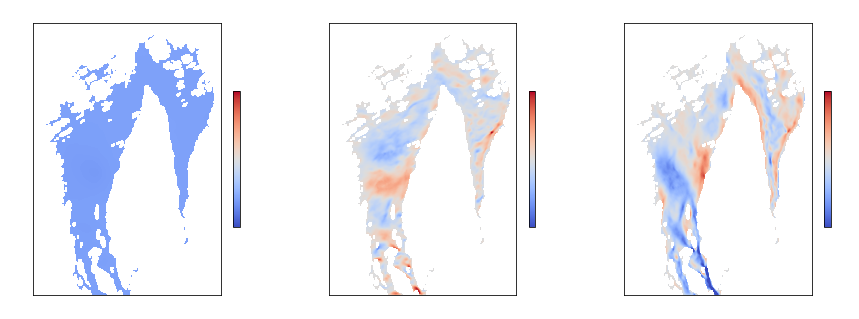

In [15]:
bt_eta, bt_hu, bt_hv = ref_barotropic_sim.download()

fig, axs = plt.subplots(1,3, figsize=(15,5))

im = axs[0].imshow(bt_eta, vmin=-0.5, vmax=0.5, cmap="coolwarm")
axs[0].set_title("eta")
plt.colorbar(im, ax=axs[0], shrink=0.5)

im = axs[1].imshow(bt_hu, vmin=-5, vmax=5, cmap="coolwarm")
axs[1].set_title("hu")
plt.colorbar(im, ax=axs[1], shrink=0.5)

im = axs[2].imshow(bt_hv, vmin=-5, vmax=5, cmap="coolwarm")
axs[2].set_title("hv")
plt.colorbar(im, ax=axs[2], shrink=0.5)

In [16]:
subt = 3600
for runt in range(int(T/subt)):
    ref_barotropic_sim.step(subt)


In [17]:
# with plt.rc_context({'lines.color':'black', 
#                         'text.color':'black', 
#                         'axes.labelcolor':'black', 
#                         'xtick.color':'black',
#                         'ytick.color':'black'}):
#     anim = animation_utils.ncAnimation(barotropic_sim.sim_writer.output_file_name, "gpuocean", comment="GPUOcean")
#     anim.save("anims/barotropic_test.mp4")

### Barotropic Drifters

In [18]:
barotropic_wind_angles_degs = np.arange(35, 56, 10)
barotropic_wind_samples = [None]*len(barotropic_wind_angles_degs)

for i in range(len(barotropic_wind_angles_degs)):
    barotropic_wind_samples[i] = generate_wind_field(barotropic_wind_angles_degs[i], t_start, T)

In [ ]:
# Barotropic data args by starting from earlier timesteps and doing a sufficient spin-up
barotropic_data_args = []

spinup_t = 24

spinup_barotropic_data_args = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=[np.arange(t_start-spinup_t, t_start+1)], norkyst_data=False, land_value=0.0, download_data=False)
spinup_barotropic_data_args.pop("wind")

for wind_direction in barotropic_wind_angles_degs:
    print(wind_direction)
    wind = WindStress.WindStress(t=[0], wind_u=[np.array([[np.cos(np.deg2rad(wind_direction))*10]]).astype(np.float32)], wind_v=[np.array([[np.sin(np.deg2rad(wind_direction))*10]]).astype(np.float32)])
    spinup_barotropic_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(spinup_barotropic_data_args), dt=0.0, wind=wind)
    spinup_barotropic_sim.step(spinup_t*3600)
    eta, hu, hv = spinup_barotropic_sim.download()

    spunup_barotropic_data_args = copy.copy(ref_barotropic_data_args)
    spunup_barotropic_data_args["eta0"] = eta
    spunup_barotropic_data_args["hu0"] = hu
    spunup_barotropic_data_args["hv0"] = hv
    spunup_barotropic_data_args["wind"] = generate_wind_field(wind_direction, t_start, T)
    barotropic_data_args.append(spunup_barotropic_data_args)

In [ ]:
barotropic_sims = []

for i in range(len(barotropic_data_args)):
        barotropic_sims.append( CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(barotropic_data_args[i]), wind=barotropic_wind_samples[i],  dt=0.0))

In [ ]:
windage_samples = np.arange(0.0, 0.051, 0.025)

In [48]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [ ]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': ref_barotropic_sim.nx, 'ny': ref_barotropic_sim.ny,
                'domain_size_x': ref_barotropic_sim.nx*ref_barotropic_sim.dx,
                'domain_size_y': ref_barotropic_sim.ny*ref_barotropic_sim.dy,
                'land_mask': ref_barotropic_sim.getLandMask()
                }

trajectories = Observation.Observation(**observation_args)

In [50]:
initx = [ 6000, 8000, 5000,  12000, 15000, 4000]
inity = [12000, 3000, 7500, 22000, 16000, 15000]

num_drifters = len(initx)

In [ ]:
import pandas as pd
ref_table = pd.DataFrame(columns=["drifter_id", "barotropic_id", "windage_id"]).set_index("drifter_id")

for bt in range(len(barotropic_sims)):
    for wind in range(len(windage_samples)):
        ref_table.loc[len(ref_table.index)] = [bt, wind]

In [ ]:
ref_table

In [ ]:
crossbt_trajectories = []
for cp in range(len(ref_table)):
    crossbt_trajectories.append(copy.deepcopy(trajectories))

In [ ]:
crossbt_drifters = []
for cp in range(len(ref_table)): 
    drifters = GPUDrifterCollection.GPUDrifterCollection(barotropic_gpu_ctx, # OBS: This is used for wind drift! 
                                                    num_drifters,
                                                    boundaryConditions = ref_barotropic_sim.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = ref_barotropic_sim.gpu_stream,
                                                    wind = barotropic_wind_samples[ref_table.iloc[cp].barotropic_id], # using the barotropic wind
                                                    wind_drift_factor = windage_samples[ref_table.iloc[cp].wind_drift_factor_id])          

    drifter_pos_init = np.array([initx, inity]).T
    drifters.setDrifterPositions(drifter_pos_init)
    crossbt_drifters.append(drifters)

In [ ]:
from itertools import compress

for bt in range(len(barotropic_sims)):
    barotropic_sims[bt].attachCrossProductDrifters( 
        list(compress(crossbt_drifters, ref_table["barotropic_id"] == bt)), 
        int(np.sum(ref_table["barotropic_id"] == bt))* [None] )

In [ ]:
for d in range(len(crossbt_drifters)):
    crossbt_trajectories[d].add_observation_from_drifters(crossbt_drifters[d], 0.0)

In [ ]:
for bt in range(len(barotropic_sims)):
    drifter_ids = ref_table.index[ref_table["baroclinic_id"]==bt].tolist()
    while barotropic_sims[bt].t < T:
        barotropic_sims[bt].step(360)
        for d in drifter_ids:
            crossbt_trajectories[d].add_observation_from_drifters(crossbt_drifters[d], barotropic_sims[bt].t)

In [ ]:
def plot_cp_trajectories(crossprod_trajectories, drifter_id):
    with plt.rc_context({'lines.color':'black', 
                            'text.color':'black', 
                            'axes.labelcolor':'black', 
                            'xtick.color':'black',
                            'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax.tick_params(axis='both', which='major', labelsize=28)
        domain_extent = [0, ref_barotropic_sim.nx*ref_barotropic_sim.dx/1000, 0, ref_barotropic_sim.ny*ref_barotropic_sim.dy/1000]

        bg_cmap = copy.deepcopy(plt.cm.Blues)
        bg_cmap.set_bad("grey", alpha = 1.0)

        ax.imshow(ref_barotropic_sim[0].download()[0] > -10, interpolation="none", origin='lower', 
                        cmap=bg_cmap,  
                        extent=domain_extent)

        path = crossprod_trajectories[0].get_drifter_path(drifter_id, 0, T, in_km = True)[0]
        start_pos = path[0,:]
        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                0.01, color = 'black', fill=True, zorder=10)
        ax.add_patch(circ_start)

        for path in [t.get_drifter_path(drifter_id, 0, T, in_km = True)[0] for t in crossprod_trajectories]:
            
            ax.plot(path[:,0], path[:,1], color="C0", ls="-", zorder=5, alpha=0.1)
            
            end_pos = path[-1,:]
            ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=100, linewidths=2, alpha=0.5)

        plt.tight_layout()

        # plt.savefig("figs/BTdrift"+str(drifter_id)+".pdf", bbox_inches="tight")


In [ ]:

for drifter_id in range(num_drifters):
    plot_cp_trajectories(crossbt_trajectories, drifter_id)